# Application of neural networks - Swiss Roll
#### The objective is to approximate, using a neural network, the mapping that unfolds the Swiss Roll manifold from its three-dimensional embedding into its intrinsic two-dimensional representation.
#### This notebook trains such a small feedforward neural network with the sigmoid activation function. Run the cells in sequence to obtain the remarkable result and observe *the Universal Approximation Theorem* in "practice".

## 1 — Definitions
Contains imports, helper functions, network & optimizer implementations as well as training


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D

# sklearn for supervised MLP
from sklearn.neural_network import MLPRegressor

# reproducibility for data generation
RNG_SEED = 42
np.random.seed(RNG_SEED)


# ------------------------
# Data generation
# ------------------------
def make_swiss_roll(n_samples=1000, noise=0.0, random_state=None):
    rng = np.random.RandomState(random_state)
    _t = (3.0 * np.pi / 2.0) * (1.0 + 2.0 * rng.rand(n_samples))
    _x1 = _t * np.cos(_t)
    _x3 = _t * np.sin(_t)
    _x2 = 21.0 * rng.rand(n_samples)
    _X = np.vstack([_x1, _x2, _x3]).T
    if noise > 0.0:
        _X += noise * rng.randn(*_X.shape)
    t_norm = (_t - _t.min()) / (_t.max() - _t.min())
    y_norm = (_x2 - _x2.min()) / (_x2.max() - _x2.min())
    _Y = np.vstack([t_norm, y_norm]).T
    return _X, _Y, _t, _x2


# --------------------------------------
# Helpfunction to create supervised MLP (sklearn)
# --------------------------------------
def create_classic_mlp(num_hidden, num_neurons, lr=0.005, batch_size=128, epochs=2000, seed=0, verbose=False):
    hidden_sizes = (int(num_neurons),) * int(num_hidden)
    model = MLPRegressor(
        hidden_layer_sizes=hidden_sizes,
        activation='logistic',
        solver='adam',
        learning_rate_init=float(lr),
        batch_size=int(batch_size),
        max_iter=int(epochs),
        tol=0.0,                      # disable stopping based on tol
        n_iter_no_change=int(epochs), # large, so no early stopping due to lack of improvement
        random_state=int(seed),
        verbose=verbose
    )
    return model



## 2 — Data sample & quick plots
This cell draws datapoints from the dataset and shows two 3D subplots side-by-side (full view and front view).

Additionaly, some points of the dataset will be printed out.


Random 20 datapoints (rows = x1, x2, x3):
[[  5.54294944   5.34808306 -10.07436862]
 [  2.16185798  20.47065641  -4.66981897]
 [ 12.05303114  18.06257034  -2.68064997]
 [ -7.63283015   7.41827958  -6.6810293 ]
 [  0.58113097   1.73000196   7.75747238]
 [ 10.3072421   12.29244165   8.3187576 ]
 [  5.43197247   5.56597499  -2.2702554 ]
 [  9.96821527   4.84406605  -6.64237504]
 [  3.48720482  14.60481134   6.48189473]
 [  1.13788332  12.95546529 -11.03979616]
 [ -8.24939976  19.82959627   3.62504769]
 [  9.58791082  16.18935874   9.26759928]
 [  5.72871583  11.91355661   3.78702763]
 [  5.82727586  12.17965954  -1.53394574]
 [ -1.42130066   0.19596402 -10.77100612]
 [ -7.56013022   0.1037396    4.64620978]
 [ -6.75567663  11.56800478   5.54163522]
 [ 10.2376498   11.98280468   8.41869109]
 [  4.04139781   0.75936799  -3.77698679]
 [ -5.63236871   7.73450014   6.46053507]]


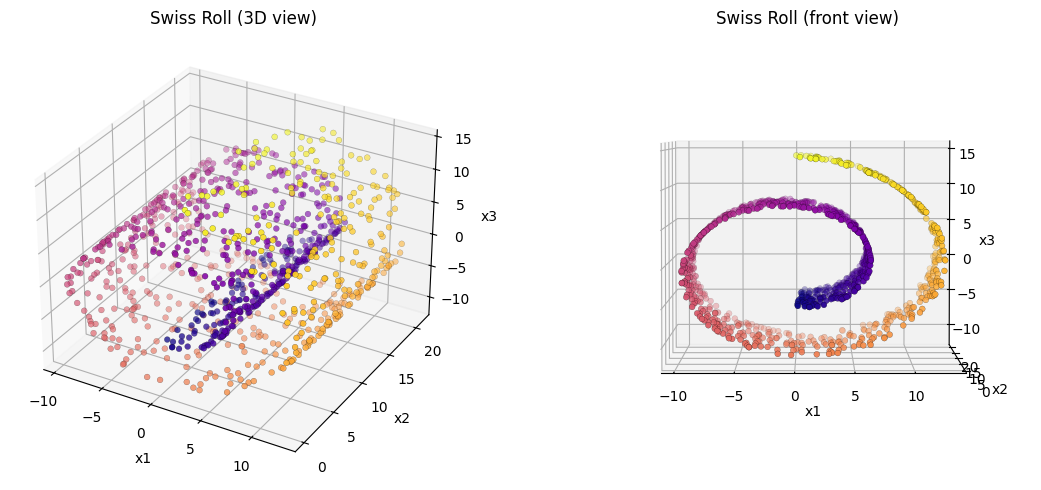

In [ ]:
# Create data points
X_raw, Y_true, t_raw, y_raw = make_swiss_roll(n_samples=1000, noise=0.0, random_state=RNG_SEED)

rng = np.random.RandomState(7)
idxs20 = rng.choice(np.arange(X_raw.shape[0]), size=20, replace=False)
sample20 = X_raw[idxs20]
print('Random 20 datapoints (rows = x1, x2, x3):')
print(sample20)

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1, projection='3d')
colors = plt.cm.plasma((t_raw - t_raw.min())/(t_raw.max()-t_raw.min()))

# Plot Swiss Role in 3D space view 
ax1.scatter(X_raw[:,0], X_raw[:,1], X_raw[:,2], s=18, c=colors, edgecolors='k', linewidth=0.15)
ax1.set_title('Swiss Roll (3D view)')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('x3')

# Plot Swiss Role in front view 
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.scatter(X_raw[:,0], X_raw[:,1], X_raw[:,2], s=18, c=colors, edgecolors='k', linewidth=0.15)
ax2.view_init(elev=3, azim=-90)
ax2.set_title('Swiss Roll (front view)')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('x3')

plt.tight_layout()
plt.show()



#-------------------------------------------------------------------------
# Plotting Swiss Role with its manifold (picture will be saved)
#
# Uncomment (end of this cell) for generating and saving the plot in svg)
#-------------------------------------------------------------------------

def plot_manifild():
    figExt = plt.figure(figsize=(8, 6))
    ax3 = figExt.add_subplot(111, projection='3d')

    ax3.scatter(X_raw[:, 0], X_raw[:, 1], X_raw[:, 2], s=14, alpha=0.95, c=colors, edgecolors='k', linewidth=0.15)

    # Create manifold (surface)
    t_min, t_max = t_raw.min(), t_raw.max()
    y_min, y_max = y_raw.min(), y_raw.max()
    t_lin = np.linspace(t_min, t_max, 200)
    y_lin = np.linspace(y_min, y_max, 80)
    T, Yg = np.meshgrid(t_lin, y_lin)
    X_surf = T * np.cos(T)
    Z_surf = T * np.sin(T)

    # Coloring manifold
    cmap = plt.cm.plasma
    norm_T = (T - t_min) / (t_max - t_min)
    surf_colors = cmap(norm_T)

    ax3.plot_surface(X_surf, Yg, Z_surf, rstride=1, cstride=1, facecolors=surf_colors, linewidth=0, antialiased=True, alpha=0.20)
    ax3.set_title("Swiss Roll with semi-transparent surface overlay")
    ax3.set_xlabel("x1")
    ax3.set_ylabel("x2")
    ax3.set_zlabel("x3")
    ax3.view_init(elev=15, azim=-80)

    plt.tight_layout()
    figExt.savefig('swiss_plot_3.svg', format='svg', bbox_inches='tight')
    plt.close(figExt)

# plot_manifild() # UNCOMMENT

## 3 — Build network & run training (execute this cell to start training)
- **What training does:** adjusts weights to reduce reconstruction error.
- **What Adam does:** adaptive per-parameter step-size optimizer.
- This cell will print epoch losses as training progresses.


In [5]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import numpy as np
from sklearn.datasets import make_swiss_roll
from sklearn.neural_network import MLPRegressor

# -----------------------
# Hyperparameters / config
# -----------------------
num_hidden = 3  # TOTAL hidden layers
num_neurons = 8  # neurons per hidden layer
LR = 0.005
BATCH_SIZE = 128
EPOCHS = 2000
SEED = 2
TRAIN_SUPERVISED = True

# -----------------------
# Does data exist? (try to use pre-defined variables otherwise generate demo)
# -----------------------
try:
    # If these exist in the namespace, keep them
    X_raw
    Y_true
    t_raw
    y_raw
except NameError:
    print("X_raw/Y_true not found — generating demo Swiss-roll dataset.")
    X_raw, t_raw = make_swiss_roll(n_samples=1000, noise=0.0, random_state=SEED)
    # In many swiss-roll helpers, Y is the unrolled coordinates; here we'll craft a toy 2D target
    # t_raw is the "unrolled" 1D coordinate returned by make_swiss_roll; create a 2D target for demo:
    Y_true = np.column_stack([t_raw, np.zeros_like(t_raw)])  # replace with your true target

# -----------------------
# Normalize inputs
# -----------------------
Xn = (X_raw - X_raw.mean(axis=0)) / X_raw.std(axis=0)

# -----------------------
# Build sklearn MLPRegressor with warm_start for manual epoch loop
# -----------------------
hidden = tuple([num_neurons] * num_hidden)
net = MLPRegressor(
    hidden_layer_sizes=hidden,
    learning_rate_init=LR,
    batch_size=BATCH_SIZE,
    max_iter=1,   # run exactly one iteration per .fit() call
    warm_start=True,  # keep training state between .fit() calls
    random_state=SEED,
    solver="adam",
    shuffle=True,
    tol=1e-9, # small tol so training won't stop early
    verbose=False
)

# -----------------------
# Training loop (one epoch per fit call)
# -----------------------
if TRAIN_SUPERVISED:
    print("Training supervised MLP (X -> Y_true) with warm_start loop...")
    for epoch in range(1, EPOCHS + 1):
        net.fit(Xn, Y_true)    # performs one iteration / epoch

        # Print loss at epoch 1, every 200 epochs, and final epoch
        if epoch == 1 or (epoch % 200 == 0) or (epoch == EPOCHS):
            # net.loss_ is updated after .fit()
            print(f"Epoch {epoch:4d}: loss = {net.loss_:.6f}")

# -----------------------
# Final prediction
# -----------------------
Y_pred = net.predict(Xn)
Y_pred = np.asarray(Y_pred)
if Y_pred.ndim == 1:
    Y_pred = Y_pred.reshape(-1, 1)

# -----------------------
# Store weights and biases for plotting/utilities if needed
# -----------------------
try:
    W_list = [w.copy() for w in net.coefs_]
    b_list = [b.copy() for b in net.intercepts_]
except Exception:
    W_list = None
    b_list = None

print("Training finished")

Training supervised MLP (X -> Y_true) with warm_start loop...
Epoch    1: loss = 0.154358
Epoch  200: loss = 0.000344
Epoch  400: loss = 0.000315
Epoch  600: loss = 0.000294
Epoch  800: loss = 0.000220
Epoch 1000: loss = 0.000237
Epoch 1200: loss = 0.000179
Epoch 1400: loss = 0.000184
Epoch 1600: loss = 0.000157
Epoch 1800: loss = 0.000140
Epoch 2000: loss = 0.000131
Training finished


## 4 — Visualize weights & biases
Heatmaps and labels show which weight connects which neuron (e.g. input1 → hidden1_neuron1).


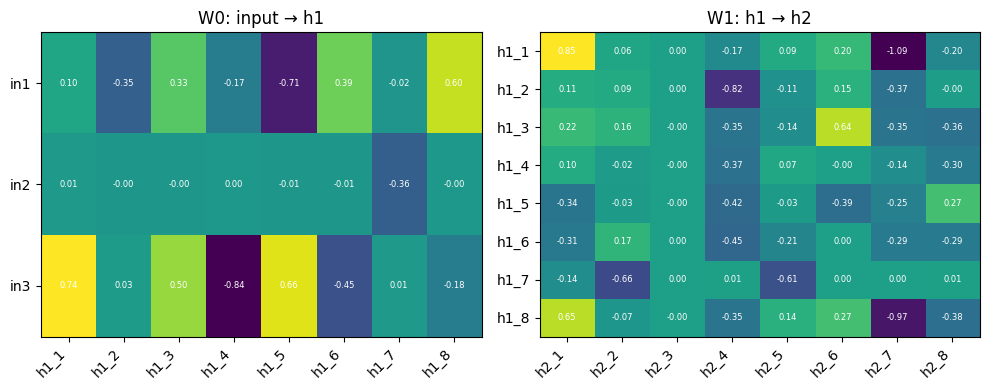

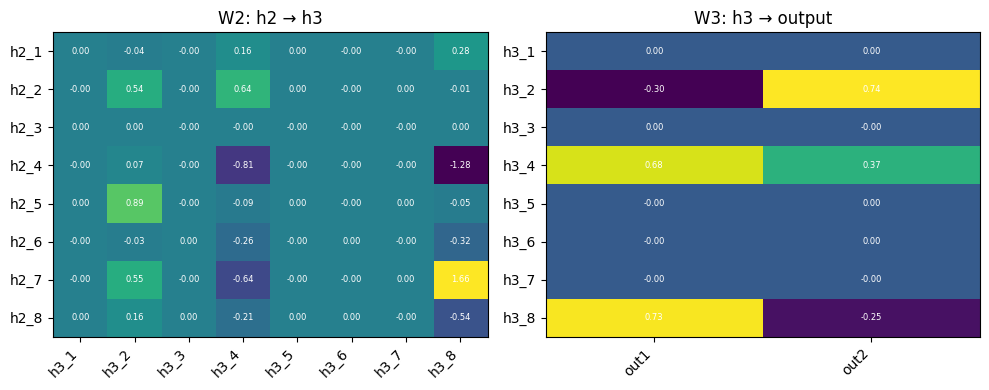

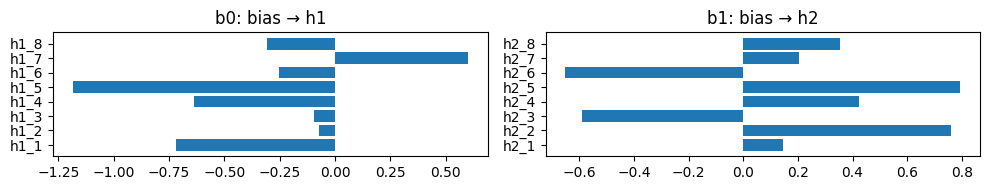

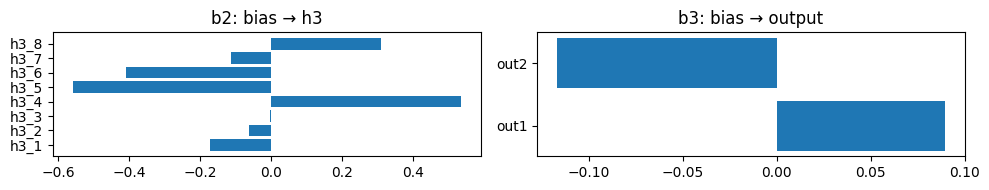

In [6]:
# -------------------------
# Helper: unified extraction of layer sizes, weights and biases from different net types
# -------------------------
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Try to import tensorflow only to allow detection if present (currently not required)
try:
    import tensorflow as tf
except Exception:
    tf = None

def _unpack_net_params(net, debug=False):
    """
    Returns (layer_sizes, W_list, b_list)
    - layer_sizes: list of node counts [n_input, n_hidden1, ..., n_output]
    - W_list: list of weight matrices with shape (in_dim, out_dim) for each layer
    - b_list: list of bias vectors with shape (out_dim,) for each layer
    Allowed networks from:
      - sklearn.neural_network.MLPRegressor (coefs_, intercepts_)
      - PyTorch-style net with attributes layer_sizes, W (property), b (property)
      - keras Model (tf.keras.Model) if available (extract Dense layers)
    """
    # PyTorch-style
    if hasattr(net, "layer_sizes") and hasattr(net, "W") and hasattr(net, "b"):
        layer_sizes = list(net.layer_sizes)
        W_list = [np.asarray(w, dtype=float).copy() for w in net.W]
        b_list = [np.asarray(bb, dtype=float).copy() for bb in net.b]
        if debug:
            print("Detected PyTorch-style net.")
            print("layer_sizes:", layer_sizes)
        return layer_sizes, W_list, b_list

    # sklearn MLPRegressor
    if hasattr(net, "coefs_") and hasattr(net, "intercepts_"):
        coefs = [np.asarray(w, dtype=float).copy() for w in net.coefs_]
        intercepts = [np.asarray(bi, dtype=float).copy() for bi in net.intercepts_]
        if len(coefs) == 0:
            raise RuntimeError("net.coefs_ is empty. Model not fitted yet?")
        layer_sizes = [int(coefs[0].shape[0])] + [int(w.shape[1]) for w in coefs]
        if debug:
            print("Detected sklearn MLPRegressor-style net.")
            print("layer_sizes derived:", layer_sizes)
        return layer_sizes, coefs, intercepts

    # Keras Model
    if tf is not None and hasattr(net, "layers"):
        dense_layers = [L for L in net.layers if isinstance(L, tf.keras.layers.Dense)]
        if len(dense_layers) > 0:
            W_list = []
            b_list = []
            for L in dense_layers:
                weights = L.get_weights()
                if len(weights) == 2:
                    W, b = weights
                elif len(weights) == 1:
                    W = weights[0]
                    b = np.zeros(W.shape[1], dtype=float)
                else:
                    continue
                W_list.append(np.asarray(W, dtype=float).copy())
                b_list.append(np.asarray(b, dtype=float).copy())
            layer_sizes = [int(W_list[0].shape[0])] + [int(W.shape[1]) for W in W_list]
            if debug:
                print("Detected Keras Model with Dense layers.")
                print("layer_sizes derived:", layer_sizes)
            return layer_sizes, W_list, b_list

    # Fallback: direct W and b attributes (lists)
    if hasattr(net, "W") and hasattr(net, "b"):
        W_list = [np.asarray(w, dtype=float).copy() for w in net.W]
        b_list = [np.asarray(bb, dtype=float).copy() for bb in net.b]
        layer_sizes = [int(W_list[0].shape[0])] + [int(W.shape[1]) for W in W_list]
        return layer_sizes, W_list, b_list

    raise RuntimeError("Could not find network parameters. Provide a fitted sklearn MLPRegressor, a Keras model, or a net with .layer_sizes/.W/.b.")


# -------------------------
# small helper to plot a single weight matrix
# -------------------------
def _plot_single_weight(W, src_labels, tgt_labels, ax, title=''):
    W = np.asarray(W, dtype=float)
    im = ax.imshow(W, aspect='auto', interpolation='nearest')
    # only set tick labels if sizes are reasonable
    if len(src_labels) <= 60:
        ax.set_yticks(np.arange(len(src_labels)))
        ax.set_yticklabels(src_labels)
    else:
        ax.set_yticks([])

    if len(tgt_labels) <= 60:
        ax.set_xticks(np.arange(len(tgt_labels)))
        ax.set_xticklabels(tgt_labels, rotation=45, ha='right')
    else:
        ax.set_xticks([])

    ax.set_title(title)
    # annotate with numbers only if small
    if W.size <= 400:
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                ax.text(j, i, f"{W[i,j]:.2f}", ha='center', va='center', fontsize=6, color='w')
    return im

# -------------------------
# pairwise plotting for weights: two matrices per figure
# -------------------------
def pairwise_plot_weights(net, max_pairs=None, figsize_per_subplot=(5,4), debug=False):
    # get unified parameters
    layer_sizes, W_list, b_list = _unpack_net_params(net, debug=debug)

    n_weights = len(W_list)
    if debug:
        print("layer_sizes:", layer_sizes)
        print("n_weights:", n_weights)

    # create layer label lists
    layer_labels = []
    layer_labels.append([f'in{i+1}' for i in range(layer_sizes[0])])
    for hid_idx in range(1, len(layer_sizes)-1):
        nb = layer_sizes[hid_idx]
        layer_labels.append([f'h{hid_idx}_{j+1}' for j in range(nb)])
    layer_labels.append([f'out{i+1}' for i in range(layer_sizes[-1])])

    figs = []
    pairs = [(i, i+1) for i in range(0, n_weights, 2)]
    if max_pairs is not None:
        pairs = pairs[:max_pairs]
    for p in pairs:
        idx1 = p[0]
        idx2 = p[1] if p[1] < n_weights else None

        ncols = 2 if idx2 is not None else 1
        fig, axes = plt.subplots(1, ncols, figsize=(figsize_per_subplot[0]*ncols, figsize_per_subplot[1]))
        if ncols == 1:
            axes = [axes]

        # first matrix
        W1 = np.asarray(W_list[idx1], dtype=float)
        src1 = layer_labels[idx1]
        tgt1 = layer_labels[idx1+1]
        title1 = f'W{idx1}: {"input" if idx1==0 else "h"+str(idx1)} → {"h"+str(idx1+1) if idx1+1 < len(layer_labels)-1 else "output"}'
        _plot_single_weight(W1, src1, tgt1, axes[0], title=title1)

        # second matrix (if there is one)
        if idx2 is not None:
            W2 = np.asarray(W_list[idx2], dtype=float)
            src2 = layer_labels[idx2]
            tgt2 = layer_labels[idx2+1]
            title2 = f'W{idx2}: {"input" if idx2==0 else "h"+str(idx2)} → {"h"+str(idx2+1) if idx2+1 < len(layer_labels)-1 else "output"}'
            _plot_single_weight(W2, src2, tgt2, axes[1], title=title2)

        plt.tight_layout()
        try:
            display(fig)
        except Exception:
            plt.show()
        plt.close(fig)
        figs.append(fig)

    return figs

# -------------------------
# pairwise plotting for biases (two per figure, horizontal bars)
# -------------------------
def pairwise_plot_biases(net, figsize_per_subplot=(5,2), debug=False):
    layer_sizes, W_list, b_list = _unpack_net_params(net, debug=debug)

    n_biases = len(b_list)
    if debug:
        print("layer_sizes:", layer_sizes)
        print("n_biases:", n_biases)

    layer_labels = []
    layer_labels.append([f'in{i+1}' for i in range(layer_sizes[0])])
    for hid_idx in range(1, len(layer_sizes)-1):
        nb = layer_sizes[hid_idx]
        layer_labels.append([f'h{hid_idx}_{j+1}' for j in range(nb)])
    layer_labels.append([f'out{i+1}' for i in range(layer_sizes[-1])])

    figs = []
    for i in range(0, n_biases, 2):
        idx1 = i
        idx2 = i+1 if (i+1) < n_biases else None
        ncols = 2 if idx2 is not None else 1
        fig, axes = plt.subplots(1, ncols, figsize=(figsize_per_subplot[0]*ncols, figsize_per_subplot[1]))
        if ncols == 1:
            axes = [axes]

        b1 = np.asarray(b_list[idx1]).flatten()
        labels1 = layer_labels[idx1+1] # biases correspond to destination layer
        axes[0].barh(labels1, b1)
        axes[0].set_title(f'b{idx1}: bias → {"output" if idx1+1==len(layer_labels)-1 else "h"+str(idx1+1)}')

        if idx2 is not None:
            b2 = np.asarray(b_list[idx2]).flatten()
            labels2 = layer_labels[idx2+1]
            axes[1].barh(labels2, b2)
            axes[1].set_title(f'b{idx2}: bias → {"output" if idx2+1==len(layer_labels)-1 else "h"+str(idx2+1)}')

        plt.tight_layout()
        try:
            display(fig)
        except Exception:
            plt.show()
        plt.close(fig)
        figs.append(fig)
    return figs


# Plots weights and biases of the current neural network
_ = pairwise_plot_weights(net)
_ = pairwise_plot_biases(net)


## 5 — Final comparison plots (side-by-side)
Left: dense comparison (all points). Right: focused comparison (random points with dotted lines to predictions showing error distance.).

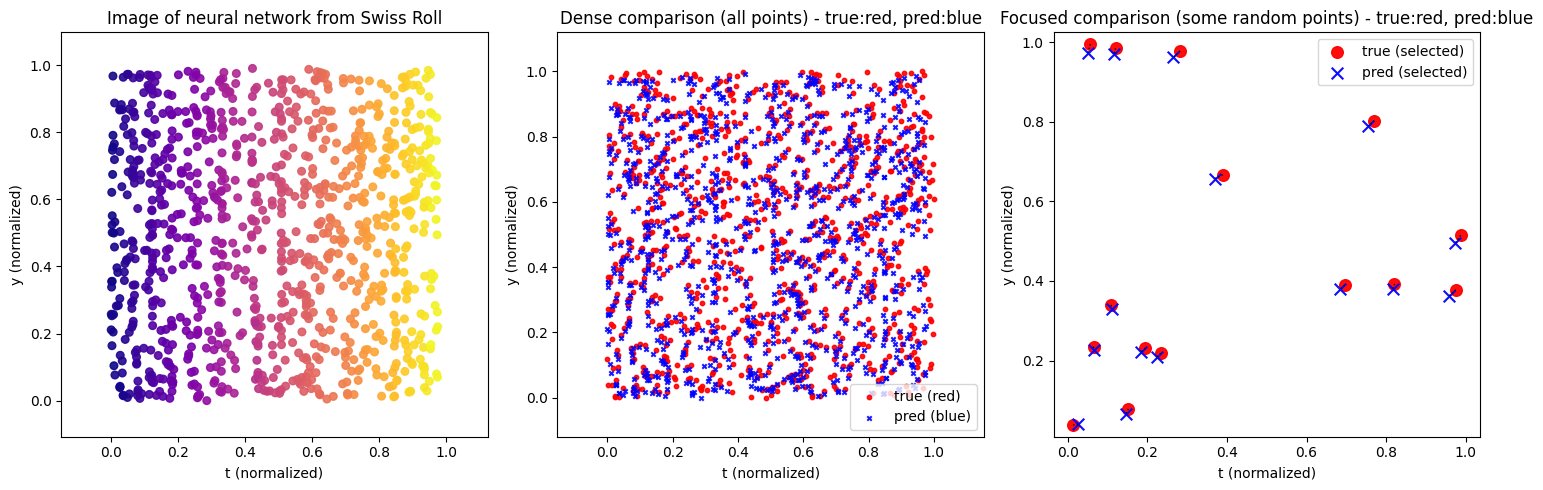

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Ensure RNG_SEED exists
try:
    RNG_SEED
except NameError:
    RNG_SEED = 42

# Prepare arrays and check shapes
Y_pred = np.asarray(Y_pred)
Y_true = np.asarray(Y_true)

if Y_pred.ndim != 2:
    raise RuntimeError(f"Y_pred must be 2D (N,2). Got ndim={Y_pred.ndim}.")
if Y_pred.shape[1] < 2:
    raise RuntimeError(f"Y_pred must have at least 2 columns for plotting. Got shape {Y_pred.shape}.")
Y_pred_plot = Y_pred[:, :2]

if Y_true.ndim != 2 or Y_true.shape[1] < 2:
    raise RuntimeError(f"Y_true must be shape (N, >=2). Found: {Y_true.shape}")
Y_true_plot = Y_true[:, :2]

# Prepare colors: prefer the `colors` from cell 2 if available, else compute from t_raw
try:
    colors  # exists?
except NameError:
    # recompute colors from t_raw (same normalization you used in cell 2)
    if 't_raw' in globals():
        colors = plt.cm.plasma((t_raw - t_raw.min()) / (t_raw.max() - t_raw.min()))
    else:
        # fallback: use Y_true t-coordinate if available
        colors = plt.cm.plasma((Y_true_plot[:,0] - Y_true_plot[:,0].min()) / (Y_true_plot[:,0].ptp() + 1e-12))

# Create 1x3 subplots: 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

# AX1: predicted 2D embedding, COLORED by original t, CIRCULAR markers (swapped role -> circle instead of cross)
ax1.scatter(Y_pred_plot[:,0], Y_pred_plot[:,1], s=30, alpha=0.9, marker='o', c=colors)
ax1.set_title('Image of neural network from Swiss Roll')
ax1.set_xlabel('t (normalized)')
ax1.set_ylabel('y (normalized)')
ax1.axis('equal')

# AX2: Dense comparison (all points) - TRUE = red (circle), PRED = blue (cross) as requested
ax2.scatter(Y_true_plot[:,0], Y_true_plot[:,1], s=10, alpha=0.9, marker='o', c='red', label='true (red)')
ax2.scatter(Y_pred_plot[:,0], Y_pred_plot[:,1], s=10, alpha=0.9, marker='x', c='blue', label='pred (blue)')
ax2.set_title('Dense comparison (all points) - true:red, pred:blue')
ax2.set_xlabel('t (normalized)')
ax2.set_ylabel('y (normalized)')
ax2.legend()
ax2.axis('equal')

# AX3: Focused comparison (random subset with connecting lines) - TRUE red circle, PRED blue cross
N = X_raw.shape[0]
rng = np.random.RandomState(RNG_SEED + 7)
idxs = rng.choice(np.arange(N), size=15, replace=False)
true_pts = Y_true_plot[idxs]
pred_pts = Y_pred_plot[idxs]

ax3.scatter(true_pts[:,0], true_pts[:,1], s=70, alpha=0.95, marker='o', label='true (selected)', c='red')
ax3.scatter(pred_pts[:,0], pred_pts[:,1], s=70, alpha=0.95, marker='x', label='pred (selected)', c='blue')

for (t_raw_val, y_raw_val), (t_p, y_p) in zip(true_pts, pred_pts):
    ax3.plot([t_raw_val, t_p], [y_raw_val, y_p], linestyle=':', color='k', linewidth=1.0)

ax3.set_title('Focused comparison (some random points) - true:red, pred:blue')
ax3.set_xlabel('t (normalized)')
ax3.set_ylabel('y (normalized)')
ax3.legend()
ax3.axis('equal')

plt.tight_layout()
plt.show()



# Function to save first plot
def manifold_projected(filename='swiss_plot_2.svg', Y=None, colors=None, t_raw=None,
                       cmap=cm.plasma, figsize=(8,6), s=30, alpha=0.9, marker='o'):
    """
    Recreate and save the 2D predicted embedding plot.
    - If Y is None, uses global Y_pred_plot or Y_pred.
    - If colors is None, uses provided t_raw or global t_raw or derives colors from Y (first column).
    - Saves to `filename` (SVG). Returns the path.
    """
    
    if Y is None:
        if 'Y_pred_plot' in globals():
            Yp = np.asarray(Y_pred_plot)
        elif 'Y_pred' in globals():
            Yp = np.asarray(Y_pred)
        else:
            raise RuntimeError("No Y provided and no global Y_pred/Y_pred_plot found.")
    else:
        Yp = np.asarray(Y)

    if Yp.ndim != 2 or Yp.shape[1] < 2:
        raise ValueError(f"Y must be shape (N, >=2). Got {Yp.shape}")

    N = Yp.shape[0]

    if colors is None:
        scalar = None
        if t_raw is not None:
            scalar = np.asarray(t_raw)
            if scalar.shape[0] != N:
                raise ValueError("t_raw length does not match Y length.")
        elif 't_raw' in globals():
            scalar = np.asarray(globals()['t_raw'])
            if scalar.shape[0] != N:
                scalar = None
        elif 'Y_true' in globals():
            Yt = np.asarray(globals()['Y_true'])
            if Yt.ndim == 2 and Yt.shape[0] == N:
                scalar = Yt[:,0]
        if scalar is None:
            scalar = Yp[:,0]
        scalar_norm = (scalar - np.min(scalar)) / (np.ptp(scalar) + 1e-12)
        colors_use = cmap(scalar_norm)
    else:
        colors_use = np.asarray(colors)
        if colors_use.shape[0] != N:
            raise ValueError("colors length does not match Y length.")

    # plot & save
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.scatter(Yp[:,0], Yp[:,1], s=s, alpha=alpha, marker=marker, c=colors_use)
    ax.set_title('Image of neural network from Swiss Roll')
    ax.set_xlabel('t (normalized)')
    ax.set_ylabel('y (normalized)')
    ax.axis('equal')
    plt.tight_layout()
    fig.savefig(filename, bbox_inches='tight')
    plt.close(fig)
    return filename


# manifold_projected() # UNCOMMENT



- The left graphic gives the image of he constructed neural network from the Swiss Roll. One can see, how smooth the colouring changes from left to right, indicating that the neural network projects the points in a meaningful structure.
- The middle graphic shows all points from the Swiss Roll dataset projected onto the plane by the continuous function that unfolds the manifold (circles). The neural network approximates this function and maps the datapoints to the 2-D plane (crosses). The plot presents an overview of how closely the neural network reproduces the original function.
- The right graphic focuses on 15 randomly chosen samples, where dotted lines connect each true point to its prediction, making the deviations easier to see. 
- Together, the plots reveal both the global accuracy of the model and the local discrepancies between individual predictions and ground truth.
- The labels t (normalized) and y (normalized) are just random names for the coordinates of the normalized rectangle resulting from unrolling the Swiss Roll.
  
### Overall, the results show that our neural network provides a precise approximation of the manifold’s unfolding map.
